In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

from parliament.utils import merge_utterance_paragraphs

In [13]:
save_dir = "./plots/word_counts/"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

### importing data

In [4]:
s = pm.Search.objects.get(id=89)

uts = pm.Utterance.objects.filter(search_matches=s).order_by('document__parlperiod__n')
texts, docsizes, ids = merge_utterance_paragraphs(uts)

# use count vectorizer to count number of occurances

In [16]:
print(len(texts))

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dtm = vectorizer.fit_transform(texts)
vocab = vectorizer.get_feature_names()

9167


In [18]:
SEARCH = re.compile('(?<!Gemeinschaft für )kohle(?!nwasser)(?!nstoff)(?!ndiox)(?!nmonox)(?!rnte)', re.IGNORECASE)
for term in vocab:
    if SEARCH.search(term):
        print(term)

_kohle
abfallkohle
aktivkohle
aktivkohlefilter
aktivkohlefiltern
alkohleinfluß
amerikakohle
anthrazitkohle
anthrazitkohlenvorkommen
antikohlekurs
antikohlepolitik
antikohleäußerungen
ausfuhrkohle
auskohlen
auslandskohle
australienkohle
auszukohlenden
bahnkohlekraftwerks
ballastkohle
ballastkohlenverstromung
ballastkohlesorten
baunkohlenbriketts
baunkohleregion
bekohlen
besatzungskohle
bestandskohlekraftwerken
billigkohle
biokohle
brandkohle
braunkohle
braunkohleabbau
braunkohleabbaufirmen
braunkohleabbaugebiete
braunkohleabbaus
braunkohleabsatz
braunkohleabsatzfeld
braunkohleajatollah
braunkohlealtlasten
braunkohlealtstandorte
braunkohleanlagen
braunkohleanteil
braunkohleanwendung
braunkohlearbeitnehmer
braunkohleausschusses
braunkohleausstieg
braunkohlebasis
braunkohlebedarf
braunkohlebenchmark
braunkohlebenchmarks
braunkohlebereich
braunkohlebereiche
braunkohleberg
braunkohlebergarbeiter
braunkohlebergbau
braunkohlebergbaues
braunkohlebergbaugebieten
braunkohlebergbaus
braunkohleberg

kohlenstrom
kohlenstädte
kohlenstäube
kohlensubstanz
kohlensubvention
kohlensyndikat
kohlensyndikats
kohlensäure
kohlensäuredruck
kohlensäureflaschen
kohlensäurefreie
kohlensäuregehalt
kohlensäuregehalts
kohlensäurehaltige
kohlensäurehaltigen
kohlentagebau
kohlentarif
kohlentarife
kohlentarifen
kohlentarifs
kohlenteerabkömmlinge
kohlentransport
kohlentransporte
kohlenunternehmen
kohlenunterschiede
kohlenutzung
kohlenutzungstechnologien
kohlenverbilligung
kohlenverbrauch
kohlenverbrauchende
kohlenverbraucher
kohlenverbrauchs
kohlenverbrauchsquote
kohlenveredlungsund
kohlenverkauf
kohlenverkaufs
kohlenverkaufsgesellschaften
kohlenverkaufsorganisation
kohlenverkaufsorganisationen
kohlenverkaufssyndikats
kohlenverkehr
kohlenverknappte
kohlenverknappung
kohlenverordnung
kohlenversand
kohlenversorgung
kohlenversorgungskrise
kohlenversorgungslage
kohlenversorgungsschwierigkeiten
kohlenverstro
kohlenverteilung
kohlenverteuerung
kohlenvertrieb
kohlenvorkommen
kohlenvorrat
kohlenvorratshaltung
k

steinkohlebengbaues
steinkohlebereich
steinkohlebergb
steinkohlebergbau
steinkohlebergbaues
steinkohlebergbaugebiete
steinkohlebergbaugebieten
steinkohlebergbauländer
steinkohlebergbaupolitik
steinkohlebergbaureviere
steinkohlebergbaurevieren
steinkohlebergbaus
steinkohlebergbauunternehmen
steinkohlebergleute
steinkohlebergwerk
steinkohlebergwerke
steinkohlebergwerken
steinkohlebergwerkes
steinkohlebergwerks
steinkohlebeschlusses
steinkohlebevorratung
steinkohleblöcke
steinkohlebranche
steinkohledebatte
steinkohleeinfuhren
steinkohleeinheit
steinkohleeinheiten
steinkohleeinsatz
steinkohleeinsatzes
steinkohleetat
steinkohlefinanzierung
steinkohlefinanzierungsgesetz
steinkohlefinanzierungsgesetzes
steinkohlefrachten
steinkohlefunktionäre
steinkohleförderer
steinkohlefördermenge
steinkohlefördertechniken
steinkohleförderung
steinkohleförderungsgesetz
steinkohlegebiete
steinkohlegebieten
steinkohlegefeuerten
steinkohlegesetz
steinkohlegesetzes
steinkohlegespräche
steinkohlegesundungsgesetz

In [19]:
ind = vocab.index("kohle")

In [20]:
occurrances = np.array(dtm.T[ind].todense())

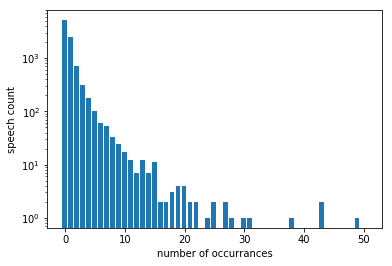

In [21]:
bins=np.arange(-1,51) + 0.5
plt.hist(occurrances[0], bins=bins, log=True, width=0.8)
plt.ylabel("speech count")
plt.xlabel("number of occurrances")

# use regular expression to count number of occurrances

In [5]:
SEARCH = re.compile('(?<!Gemeinschaft für )kohle(?!nwasser)(?!nstoff)(?!ndiox)(?!nmonox)(?!rnte)', re.IGNORECASE)

occurrances_re = np.zeros(len(texts))
for i, text in enumerate(texts):
    occurrances_re[i] = len(SEARCH.findall(text))

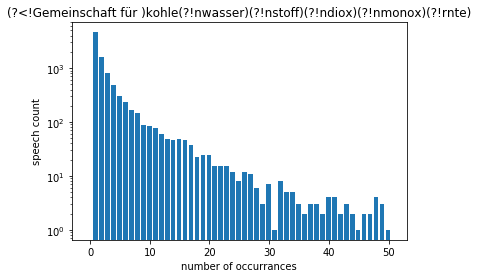

In [14]:
bins=np.arange(-1,51) + 0.5
plt.hist(occurrances_re, bins=bins, log=True, width=0.8)
plt.title("(?<!Gemeinschaft für )kohle(?!nwasser)(?!nstoff)(?!ndiox)(?!nmonox)(?!rnte)")
plt.ylabel("speech count")
plt.xlabel("number of occurrances")
plt.savefig(save_dir + 'kohle_counts_log.png')

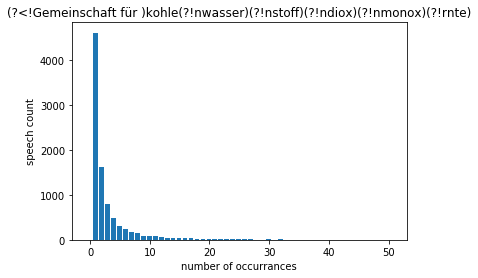

In [15]:
plt.hist(occurrances_re, bins=bins, width=0.8)
plt.ylabel("speech count")
plt.xlabel("number of occurrances")
plt.title("(?<!Gemeinschaft für )kohle(?!nwasser)(?!nstoff)(?!ndiox)(?!nmonox)(?!rnte)")
plt.savefig(save_dir + 'kohle_counts.png')

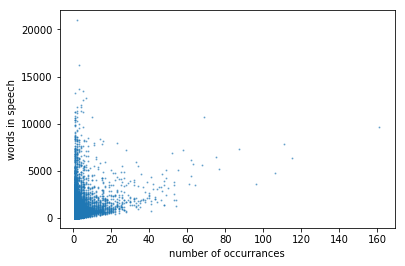

In [32]:
#speech length:

speech_length = [len(text.split(" ")) for text in texts]

plt.scatter(occurrances_re, speech_length, s=1, alpha=0.5)
plt.ylabel("words in speech")
plt.xlabel("number of occurrances")